In [5]:
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os
from tkinter import filedialog as fd
import warnings
warnings.filterwarnings('ignore')

# Set the aesthetic style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("Please choose the reformatted CSV file from TrackMate:")
fpath = fd.askopenfilename(filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Load the data
df_tracks = pd.read_csv(fpath)
print(f"Loaded data with {len(df_tracks)} spot detections across {df_tracks['trackID'].nunique()} tracks")
print(f"Frame range: {df_tracks['t'].min()} to {df_tracks['t'].max()}")

Please choose the reformatted CSV file from TrackMate:
Loaded data with 15387 spot detections across 810 tracks
Frame range: 0.0 to 50.0


In [6]:
# Cell 2: Calculate Z positions and prepare data
# Convert frame numbers (9-21) to Z-depth (0.2 µm per slice)
df_tracks['Z_um'] = (df_tracks['t'] - 9) * 0.2

# Filter to only include frames 9-21 (Z between 0 and 2.4 µm)
df_tracks = df_tracks[(df_tracks['t'] >= 9) & (df_tracks['t'] <= 21)]

print(f"After filtering to frames 9-21: {len(df_tracks)} spots remain across {df_tracks['trackID'].nunique()} tracks")

After filtering to frames 9-21: 7822 spots remain across 729 tracks


In [7]:
# Cell 3: Calculate radial displacement for all tracks
def calculate_radial_displacement(group):
    if len(group) > 0:
        x_start = group.iloc[0]['x']
        y_start = group.iloc[0]['y']
        group = group.copy()
        group['R_px'] = np.sqrt((group['x'] - x_start)**2 + (group['y'] - y_start)**2)
    return group

df_tracks = df_tracks.groupby('trackID', group_keys=False).apply(calculate_radial_displacement)

print("Calculated radial displacement (R) for all tracks")

Calculated radial displacement (R) for all tracks


In [11]:
# Cell 4: Filter for condensates visible across ALL frames 9-21, convert to microns, and save to CSV
print("\nStep 4: Filtering condensates and converting coordinates to microns...")

# Define the required frame range
required_frames = set(range(9, 22))  # frames 9 through 21 inclusive

# Check each track for presence in all required frames
complete_tracks = []
for track_id, group in df_tracks.groupby('trackID'):
    track_frames = set(group['t'].astype(int).unique())
    # Check if this track contains ALL required frames
    if required_frames.issubset(track_frames):
        # Also check for exactly one spot per frame (no duplicates)
        if all(group['t'].value_counts() == 1):
            complete_tracks.append(track_id)

print(f"Found {len(complete_tracks)} track(s) visible in ALL frames 9-21 (13 frames total)")

if len(complete_tracks) == 0:
    print("No tracks span all frames. Using tracks with ≥12 frames as fallback...")
    # Fallback: Find tracks covering most of the range
    frame_counts = df_tracks.groupby('trackID')['t'].nunique()
    complete_tracks = frame_counts[frame_counts >= 12].index.tolist()
    print(f"Using {len(complete_tracks)} tracks with ≥12 frames")

# Select 3 random tracks from the complete ones
if len(complete_tracks) < 3:
    print(f"Warning: Only {len(complete_tracks)} suitable tracks found. Using all available.")
    selected_tracks = complete_tracks
else:
    # Set random seed for reproducibility
    np.random.seed(42)
    selected_tracks = np.random.choice(complete_tracks, size=3, replace=False)

print(f"Selected {len(selected_tracks)} track(s) for analysis: {selected_tracks}")

# Extract data for selected tracks
df_selected = df_tracks[df_tracks['trackID'].isin(selected_tracks)].copy()

# Sort and organize the data
df_selected = df_selected.sort_values(['trackID', 't'])

# --- NEW: CONVERT PIXELS TO MICRONS ---
pixel_to_um = 0.1245  # Your conversion factor: 0.1245 µm/pixel

df_selected['x_um'] = df_selected['x'] * pixel_to_um
df_selected['y_um'] = df_selected['y'] * pixel_to_um

# Recalculate radial displacement USING MICRONS
def calculate_radial_displacement_um(group):
    if len(group) > 0:
        x_start = group.iloc[0]['x_um']
        y_start = group.iloc[0]['y_um']
        group = group.copy()
        group['R_um'] = np.sqrt((group['x_um'] - x_start)**2 + (group['y_um'] - y_start)**2)
    return group

df_selected = df_selected.groupby('trackID', group_keys=False).apply(calculate_radial_displacement_um)

# Create a comprehensive data structure with all necessary information (NOW IN MICRONS)
df_comprehensive = df_selected[[
    'trackID', 't', 'Z_um', 
    'x', 'y', 'x_um', 'y_um', 'R_um',  # Both pixels and microns
    'meanIntensity', 'medianIntensity', 'totalIntensity',
    'stdIntensity', 'contrast', 'SNR', 'R'
]].copy()

# Add some calculated metrics IN MICRONS
df_comprehensive['step_x_um'] = df_comprehensive.groupby('trackID')['x_um'].diff()
df_comprehensive['step_y_um'] = df_comprehensive.groupby('trackID')['y_um'].diff()
df_comprehensive['step_size_um'] = np.sqrt(
    df_comprehensive['step_x_um']**2 + df_comprehensive['step_y_um']**2
)

# Save to CSV
output_csv_path = fpath[:-4] + '_complete_condensates_data_um.csv'
df_comprehensive.to_csv(output_csv_path, index=False)
print(f"\n✓ Comprehensive data (IN MICRONS) saved to: {output_csv_path}")
print(f"  Contains {len(df_comprehensive)} data points from {len(selected_tracks)} condensates")
print(f"  Conversion: {pixel_to_um} µm/pixel")
print(f"  New columns: x_um, y_um, R_um, step_size_um")

# Display summary IN MICRONS
print("\nData summary (in microns):")
summary_stats = df_comprehensive.groupby('trackID').agg({
    'Z_um': ['min', 'max', 'count'],
    'x_um': ['mean', 'std'],
    'y_um': ['mean', 'std'],
    'R_um': ['max', 'mean']
}).round(3)

# Format the summary nicely
for track_id in selected_tracks:
    track_stats = summary_stats.loc[track_id]
    print(f"\nTrack {int(track_id)}:")
    print(f"  Z-range: {track_stats[('Z_um', 'min')]:.1f} to {track_stats[('Z_um', 'max')]:.1f} µm ({int(track_stats[('Z_um', 'count')])} points)")
    print(f"  X: {track_stats[('x_um', 'mean')]:.1f} ± {track_stats[('x_um', 'std')]:.2f} µm")
    print(f"  Y: {track_stats[('y_um', 'mean')]:.1f} ± {track_stats[('y_um', 'std')]:.2f} µm")
    print(f"  Max radial displacement: {track_stats[('R_um', 'max')]:.3f} µm")


Step 4: Filtering condensates and converting coordinates to microns...
Found 373 track(s) visible in ALL frames 9-21 (13 frames total)
Selected 3 track(s) for analysis: [542.  51.  23.]

✓ Comprehensive data (IN MICRONS) saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/fixed_cell_2x/20251219/fixed_cell_spots_reformatted_complete_condensates_data_um.csv
  Contains 39 data points from 3 condensates
  Conversion: 0.1245 µm/pixel
  New columns: x_um, y_um, R_um, step_size_um

Data summary (in microns):

Track 542:
  Z-range: 0.0 to 2.4 µm (13 points)
  X: 4.6 ± 0.01 µm
  Y: 4.9 ± 0.03 µm
  Max radial displacement: 0.078 µm

Track 51:
  Z-range: 0.0 to 2.4 µm (13 points)
  X: 7.1 ± 0.02 µm
  Y: 2.1 ± 0.02 µm
  Max radial displacement: 0.095 µm

Track 23:
  Z-range: 0.0 to 2.4 µm (13 points)
  X: 2.4 ± 0.01 µm
  Y: 6.0 ± 0.01 µm
  Max radial displacement: 0.039 µm



Step 5: Creating Z-dependence plots from micron data...
Loaded data from: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/fixed_cell_2x/20251219/fixed_cell_spots_reformatted_complete_condensates_data_um.csv
Contains 39 data points from 3 condensates
All coordinates and displacements are in microns (µm)
Creating Radial Displacement (R) vs Z plots for tracks: [ 23.  51. 542.]
  Creating Radial Displacement vs Z plot for Track 23...
    Saved to: Track_23_R_vs_Z_um.png


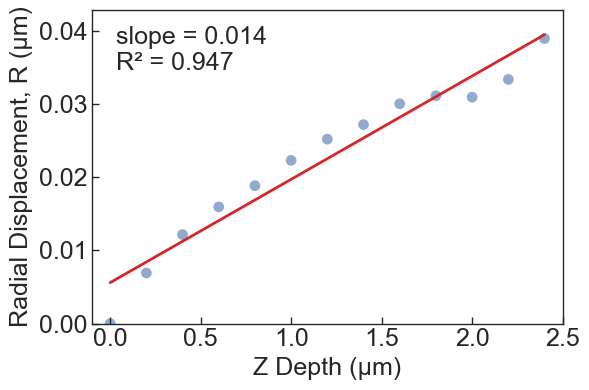

  Creating Radial Displacement vs Z plot for Track 51...
    Saved to: Track_51_R_vs_Z_um.png


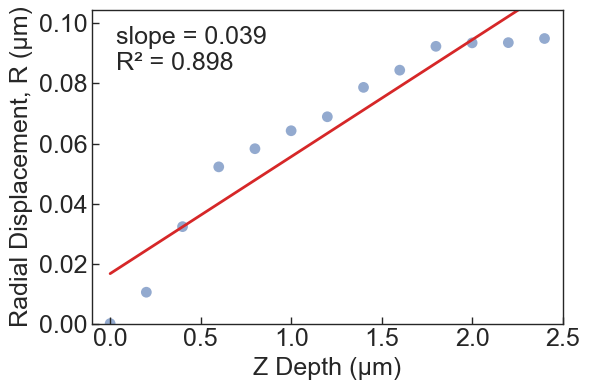

  Creating Radial Displacement vs Z plot for Track 542...
    Saved to: Track_542_R_vs_Z_um.png


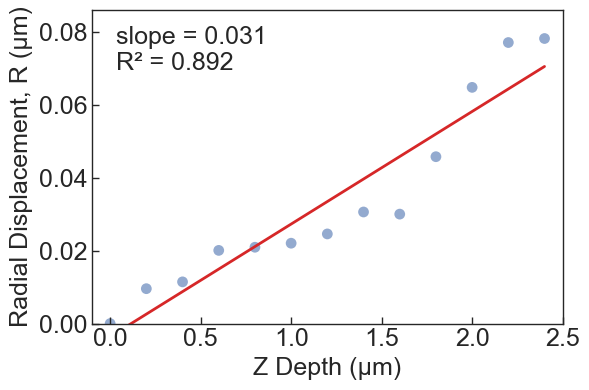


✓ Created 3 Radial Displacement vs Z plots (in microns)
✓ Plotting results saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/fixed_cell_2x/20251219/fixed_cell_spots_reformatted_R_vs_Z_results_um.csv

RADIAL DISPLACEMENT vs Z-DEPTH ANALYSIS (in microns)


,Track,Slope (∆R/∆Z),R²,Max_R (µm),N_points
0,23,0.014109,0.946580,0.038930,13
1,51,0.038954,0.897531,0.094986,13
2,542,0.030904,0.892460,0.078260,13



KEY STATISTICS (Radial Displacement):
--------------------------------------------------
Mean slope (∆R/∆Z): 0.0280  [unitless: µm/µm]
Mean |slope|: 0.0280
Mean R²: 0.9122
Range of slopes: 0.0141 to 0.0390

Original slopes in px/µm: [0.313, 0.248, 0.113]
Converted to µm/µm: ['0.0390', '0.0309', '0.0141']
(Expected vs Calculated should match closely)

INTERPRETATION:
1. Slope (∆R/∆Z): Change in radial displacement per µm of Z-change
2. Slope of 0.05 means: for every 1 µm in Z, R changes by 0.05 µm (50 nm)
3. Over 2.4 µm Z-range: max error = slope × 2.4 µm
4. Compare to localization precision (~0.06 µm) and step sizes (>0.6 µm)

ANALYSIS COMPLETE
1. Micron-scale data exported to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/fixed_cell_2x/20251219/fixed_cell_spots_reformatted_complete_condensates_data_um.csv
2. R vs Z plots saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/fixed_cell_2x/20251219
3.

In [13]:
# Cell 5: Create individual R vs Z plots FROM MICRON DATA (no grid, frameoff style)
print("\nStep 5: Creating Z-dependence plots from micron data...")

# Load the comprehensive MICRON data
plot_data_path = fpath[:-4] + '_complete_condensates_data_um.csv'
df_plot = pd.read_csv(plot_data_path)

print(f"Loaded data from: {plot_data_path}")
print(f"Contains {len(df_plot)} data points from {df_plot['trackID'].nunique()} condensates")
print(f"All coordinates and displacements are in microns (µm)")

# Get unique track IDs
selected_tracks = df_plot['trackID'].unique()
print(f"Creating Radial Displacement (R) vs Z plots for tracks: {selected_tracks}")

# Create output directory for plots
output_dir = os.path.dirname(fpath)
if not output_dir:
    output_dir = "."

# Store results for summary (SLOPES WILL NOW BE IN µm/µm)
results_summary = []

# Set style: Remove grid entirely
sns.set_style("white")

# Loop through each track - NOW ONLY CREATING R vs Z PLOTS
for track_id in selected_tracks:
    track_data = df_plot[df_plot['trackID'] == track_id].sort_values('Z_um')
    
    print(f"  Creating Radial Displacement vs Z plot for Track {int(track_id)}...")
    
    # Create figure with exact dimensions
    plt.figure(figsize=(6, 4))
    
    # Create scatter plot with exact style
    ax = plt.gca()  # Get current axis
    
    # Plot R_um vs Z_um
    plt.scatter(
        track_data['Z_um'],
        track_data['R_um'],
        color="#4C72B0",
        alpha=0.6,
        edgecolor='none',
        s=60
    )
    
    # Perform linear regression
    if len(track_data) >= 2:
        z_data = track_data['Z_um'].values
        r_data = track_data['R_um'].values
        
        slope, intercept, r_value, _, _ = linregress(z_data, r_data)
        r_squared = r_value ** 2
        
        # Store results (slope is now in µm/µm)
        results_summary.append({
            'Track': int(track_id),
            'Variable': 'R',
            'Slope (∆R/∆Z)': slope,  # Unitless ratio: µm/µm
            'Intercept (µm)': intercept,
            'R²': r_squared,
            'N_points': len(z_data),
            'Max_R (µm)': r_data.max()
        })
        
        # Plot regression line
        x_line = np.linspace(z_data.min(), z_data.max(), 100)
        y_line = slope * x_line + intercept
        
        plt.plot(x_line, y_line, color='#D62728', linestyle='-', linewidth=2)
        
        # Add equation text (slope is now unitless µm/µm)
        equation_text = f'slope = {slope:.3f}\nR² = {r_squared:.3f}'
        plt.text(0.05, 0.95, equation_text,
                 transform=ax.transAxes,
                 ha='left', va='top',
                 fontsize=18,
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set labels with exact font size
    plt.xlabel('Z Depth (µm)', fontsize=18)
    plt.ylabel('Radial Displacement, R (µm)', fontsize=18)
    
    # Apply spine and tick styling - NO GRID, "frameoff" style
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    ax.grid(False)
    ax.set_axisbelow(False)
    
    # Set axis limits with padding
    x_min, x_max = track_data['Z_um'].min(), track_data['Z_um'].max()
    y_min, y_max = track_data['R_um'].min(), track_data['R_um'].max()
    y_range = y_max - y_min
    
    plt.xlim(x_min - 0.1, x_max + 0.1)
    if y_range > 0:
        # Ensure y-axis starts at 0 or slightly below for radial displacement
        y_min_plot = max(0, y_min - y_range * 0.1)
        plt.ylim(y_min_plot, y_max + y_range * 0.1)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"Track_{int(track_id)}_R_vs_Z_um.png"
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, format="png", bbox_inches="tight", dpi=600)
    print(f"    Saved to: {plot_filename}")
    
    plt.show()

print(f"\n✓ Created {len(selected_tracks)} Radial Displacement vs Z plots (in microns)")

# Save plotting results summary
if results_summary:
    df_results = pd.DataFrame(results_summary)
    
    # Save results to CSV
    results_path = fpath[:-4] + '_R_vs_Z_results_um.csv'
    df_results.to_csv(results_path, index=False)
    print(f"✓ Plotting results saved to: {results_path}")
    
    # Display summary
    print("\n" + "="*70)
    print("RADIAL DISPLACEMENT vs Z-DEPTH ANALYSIS (in microns)")
    print("="*70)
    
    # Display the results table
    from IPython.display import display
    display(df_results[['Track', 'Slope (∆R/∆Z)', 'R²', 'Max_R (µm)', 'N_points']])
    
    # Calculate statistics
    print("\nKEY STATISTICS (Radial Displacement):")
    print("-" * 50)
    
    if len(df_results) > 0:
        mean_slope = df_results['Slope (∆R/∆Z)'].mean()
        mean_r2 = df_results['R²'].mean()
        abs_slope_mean = df_results['Slope (∆R/∆Z)'].abs().mean()
        
        print(f"Mean slope (∆R/∆Z): {mean_slope:.4f}  [unitless: µm/µm]")
        print(f"Mean |slope|: {abs_slope_mean:.4f}")
        print(f"Mean R²: {mean_r2:.4f}")
        print(f"Range of slopes: {df_results['Slope (∆R/∆Z)'].min():.4f} to {df_results['Slope (∆R/∆Z)'].max():.4f}")
        
        # Convert your original pixel slopes to µm/µm for comparison
        original_slopes_px = [0.313, 0.248, 0.113]
        converted_slopes = [s * pixel_to_um for s in original_slopes_px]
        print(f"\nOriginal slopes in px/µm: {original_slopes_px}")
        print(f"Converted to µm/µm: {[f'{s:.4f}' for s in converted_slopes]}")
        print(f"(Expected vs Calculated should match closely)")
    
    print("\n" + "="*70)
    print("INTERPRETATION:")
    print("="*70)
    print("1. Slope (∆R/∆Z): Change in radial displacement per µm of Z-change")
    print("2. Slope of 0.05 means: for every 1 µm in Z, R changes by 0.05 µm (50 nm)")
    print("3. Over 2.4 µm Z-range: max error = slope × 2.4 µm")
    print("4. Compare to localization precision (~0.06 µm) and step sizes (>0.6 µm)")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print(f"1. Micron-scale data exported to: {output_csv_path}")
    print(f"2. R vs Z plots saved to: {output_dir}")
    print(f"3. Results summary: {results_path}")